# General Instructions to students:

1. There are 4 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages, unless needed.

4. The code is to be written in Python 3.x syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/printed.

6. If TextWrite cells ask you to give accuracy/error/other numbers, you can print them on the code cells, but remove the print statements before submitting.

7. Any runtime failures on the submitted notebook will get zero marks.

8. All code must be written by you. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

10. All plots must be labelled properly, the labels/legends should be readable, all tables must have rows and columns named properly.

11. Change the name of file with your roll no. For example cs15d203.ipynb (for notebook) and cs15d203.py (for plain python script)



In [1]:
# Cell type : CodeRead

import numpy as np
import matplotlib.pyplot as plt


**Cell type : TextRead**

You are supposed to build Bayesian classifiers that model each class using multivariate Gaussian density functions for the datasets assigned to you (under assumptions below and employing MLE approach to estimate class prior/conditional densities). This assignment is focused on handling
and analyzing data using interpretable classification models, rather than aiming solely for the best classification accuracy.

Build Bayesian models for the given case numbers (you may refer to the Chapter 2 of the book “Pattern Classification" by David G. Stork, Peter E. Hart, and Richard O. Duda):

**Case 1:** Bayes classifier with the same Covariance matrix for all classes.

**Case 2:** Bayes classifier with different Covariance matrix across classes.

**Case 3:** Naive Bayes classifier with the Covariance matrix S = $σ^2I$ same for all classes.

**Case 4:** Naive Bayes classifier with S of the above form, but being different across classes.

Refer to the provided dataset for each group, which can be found [here](https://drive.google.com/drive/folders/1NmqA9lkxXayVaCzEfRgSxSxCYSa0LEZu?usp=sharing). Each dataset includes 2D feature vectors and their corresponding class labels. There are two different datasets available:
1) Linearly separable data.
2) Non-linearly separable data.

There are 41 folders in each dataset, but you need to look at only one folder -- **the folder number assigned to you** being *RollNo\%41 + 1*.

Sample plots: [link](https://drive.google.com/drive/folders/1jhauePXVWVnmUEkmZeutuhlzosTRz1sU)




In [ ]:
# Cell type : CodeWrite

def estimateMean(data):
    """ Find the ML estimate of the mean of n-dimensional data points belonging to a class.

    Arguments:
    data: 2d array containing features

    Returns:
    meanData: mean of the n-dimensional data points

    """
    # class_conditional_mean = np.mean(data[:, :2], axis=0)
    class_conditional_mean = np.mean(data, axis=0)
    return class_conditional_mean.reshape(-1, 1) # 2x1

def estimateCovariance(data):
    """ Find the ML estimate of the covariance matrix of n-dimensional data points.

    Arguments:
    data: 2d array containing features

    Returns:
    covData: covariance of the n-dimensional data points

    """
    cov_matrix = np.cov(data[:,0],data[:,1], rowvar=False)
    return cov_matrix # 2x2

def estimate_naive_sigma(data, means):
    """
    Estimate naive covariance matrix σ² I (shared or class-specific).
    
    Parameters
    ----------
    data : ndarray
        - Case 3: shape (N,3), columns [x1, x2, label]
        - Case 4: shape (N,2), only features of one class
    means : dict
        Dictionary of means {class: mean_vector}, mean_vector is (2,1)
    
    Returns
    -------
    sigma : ndarray
        d x d covariance matrix = σ² I
    """
    if data.shape[1] == 3:
        # Case-3: dataset has labels
        X = data[:, :2]
        labels = data[:, 2].astype(int)
    else:
        # Case-4: dataset has no labels, assume all belong to the same class
        X = data
        labels = np.full(X.shape[0], list(means.keys())[0], dtype=int)

    n, d = X.shape
    total_variance = 0.0
    for i in range(n):
        mu = means[labels[i]]
        total_variance += np.sum((X[i].reshape(-1,1) - mu)**2)

    sigma_squared = total_variance / (n * d)
    return sigma_squared * np.eye(d)



def computeLikelihood(dataPoint, meanData, covData):
    """ Computes the likelihood score of a data point with respect to a given class
    given the class' mean and covariance matrix

    Arguments:
    dataPoint: an n-dimensional feature vector (2x1 here)
    meanData: mean of the class (2x1 here)
    covData: covariance matrix of the class (2x2 here)

    Returns:
    likelihood: likelihood score of the data point wrt the given class

    """
    inv_cov = np.linalg.inv(covData)
    det_cov = np.linalg.det(covData)
    likelihood = 1/((2* np.pi)*np.sqrt(det_cov)) * np.exp(-0.5 * (dataPoint -meanData).T @ inv_cov @ (dataPoint - meanData))
    return likelihood

def compute_priors(train_data):
    _, counts = np.unique(train_data[:,2], return_counts=True)
    return counts / counts.sum()

def classify_point(point, means, covs, priors):
    scores = []
    for mean, cov, prior in zip(means, covs, priors):
        likelihood = computeLikelihood(point.reshape(-1,1), mean.reshape(-1,1), cov)
        scores.append(likelihood * prior)
    return np.argmax(scores) + 1  # classes {1,2,3}

def compute_error_rate(test_data, means, covs, priors):
    errors = 0
    for x1, x2, label in test_data:
        pred = classify_point(np.array([x1, x2]), means, covs, priors)
        if pred != int(label):
            errors += 1
    return errors / len(test_data)

def extract_means_and_covs(means_dict, covs_dict, case, shared=True):
    means = [means_dict[f"{i}train_conditional_mean_case{case}"].flatten()
             for i in range(1, 4)]
    if shared:  # case 1: shared covariance
        covs = [covs_dict[f"{i}train_conditional_covariance_case{case}"]
                for i in range(1, 4)]
    else:       # case 2: different covariance
        covs = [covs_dict[f"{i}train_conditional_covariance_Matrix_case{case}"]
                for i in range(1, 4)]
    return means, covs

def make_grid(xmin, xmax, ymin, ymax, n=200):
    x = np.linspace(xmin, xmax, n)
    y = np.linspace(ymin, ymax, n)
    X, Y = np.meshgrid(x, y)
    return X, Y, np.dstack((X, Y))

from scipy.stats import multivariate_normal
def plot_pdf(means, covs, grid, title,ax, azim=60, elev=10, z_offset=-0.02):
    X, Y, pos = grid
    #  pos dimensions: (n, n, 2)
    colors = ["green", "red", "blue"]
    labels = [r"Class 1", r"Class 2", r"Class 3"]
    handles = []

    for mean, cov, color, label in zip(means, covs, colors, labels):
        rv = multivariate_normal(mean, cov)
        Z = rv.pdf(pos)

        ax.plot_surface(X, Y, Z, color=color, alpha=0.6, linewidth=0)

        ax.contour(X, Y, Z, zdir="z", offset=z_offset, colors=color, linewidths=1)

        handles.append(plt.Line2D([0], [0], color=color, lw=3, label=label))

    ax.set_title(title)
    ax.set_xlabel("x_1"); ax.set_ylabel("x_2"); ax.set_zlabel("Density")
    ax.set_zlim(z_offset, None) 
    ax.view_init(elev=elev, azim=azim)
    ax.legend(handles=handles, loc="upper right")

def plot_bayes_decision_boundary(means, covs, data, title, grid, ax):
    colors = ["green", "red", "black"]
    contour_color = ['fuchsia', 'yellow', 'cyan']

    X, Y, pos = grid
    grid_points = pos.reshape(-1, 2)  # shape (n^2, 2)

    priors = compute_priors(data)

    Z_class = np.array([
        classify_point(pt, means, covs, priors)
        for pt in grid_points
    ]).reshape(X.shape)

    ax.contourf(X, Y, Z_class, alpha=0.5,
                levels=np.arange(1, len(means)+2)-0.5,
                colors=contour_color)

    for i, (mean, cov, color) in enumerate(zip(means, covs, colors), start=1):
        Z_density = np.array([
            computeLikelihood(pt.reshape(-1,1), mean.reshape(-1,1), cov)
            for pt in grid_points
        ]).reshape(X.shape)
        ax.contour(X, Y, Z_density, colors=color, levels=5, linewidths=1)

    for i, color in enumerate(colors, start=1):
        pts = data[data[:,2] == i]
        ax.scatter(pts[:,0], pts[:,1],
                   facecolors='none', edgecolors=color, label=f"Class {i}")

    ax.set_title(title)
    ax.set_xlabel("x_1"); ax.set_ylabel("x_2")
    ax.legend(fontsize=8)

In [ ]:
# Cell type : CodeWrite
# write your code here as instructed.
# (Use the functions written previously)


# Read the train data

LS_train = np.loadtxt('data/LinearlySeperable/train.txt', delimiter=',') 
NLS_train = np.loadtxt('data/NonLinearlySeperable/train.txt', delimiter=',')
LS_train = np.array(LS_train) # 1050x3
NLS_train = np.array(NLS_train) # 1050x3

# Compute the mean and the covariance matrices as per the 4 cases mentioned above
LS_means = {}
LS_covariances = {}
NLS_means = {}
NLS_covariances = {}
for i in range(1, 4):
    # Case-1 shared covariance matrix
    LS_means[f"{i}train_conditional_mean_case1"] = estimateMean(LS_train[LS_train[:, 2] == i][:, 0:2])
    NLS_means[f"{i}train_conditional_mean_case1"] = estimateMean(NLS_train[NLS_train[:, 2] == i][:, 0:2])
    LS_covariances[f"{i}train_conditional_covariance_case1"] = estimateCovariance(LS_train[:, :2])
    NLS_covariances[f"{i}train_conditional_covariance_case1"] = estimateCovariance(NLS_train[:, :2])

    # Case-2 different covariance matrix
    LS_means[f"{i}train_conditional_mean_case2"] = estimateMean(LS_train[LS_train[:, 2] == i][:, 0:2]) 
    LS_covariances[f"{i}train_conditional_covariance_Matrix_case2"] = estimateCovariance(LS_train[LS_train[:, 2] == i][:, 0:2]) 
    NLS_means[f"{i}train_conditional_mean_case2"] = estimateMean(NLS_train[NLS_train[:, 2] == i][:, 0:2]) 
    NLS_covariances[f"{i}train_conditional_covariance_Matrix_case2"] = estimateCovariance(NLS_train[NLS_train[:, 2] == i][:, 0:2]) 

    # Case-3 shared naive covariance matrix (one variance across all classes)
    LS_means[f"{i}train_conditional_mean_case3"] = estimateMean(LS_train[LS_train[:, 2] == i][:, 0:2])
    NLS_means[f"{i}train_conditional_mean_case3"] = estimateMean(NLS_train[NLS_train[:, 2] == i][:, 0:2])
    # Case-4 different naive covariance matrix (class-specific variance)
    LS_means[f"{i}train_conditional_mean_case4"] = estimateMean(LS_train[LS_train[:, 2] == i][:, 0:2])
    NLS_means[f"{i}train_conditional_mean_case4"] = estimateMean(NLS_train[NLS_train[:, 2] == i][:, 0:2])


for i in range(1, 4):
    LS_covariances[f"{i}train_conditional_covariance_case3"] = estimate_naive_sigma(
        LS_train, {c: LS_means[f"{c}train_conditional_mean_case3"] for c in range(1, 4)}
    )
    NLS_covariances[f"{i}train_conditional_covariance_case3"] = estimate_naive_sigma(
        NLS_train, {c: NLS_means[f"{c}train_conditional_mean_case3"] for c in range(1, 4)}
    )
    LS_covariances[f"{i}train_conditional_covariance_Matrix_case4"] = estimate_naive_sigma(
        LS_train[LS_train[:, 2] == i][:, 0:2], {i: LS_means[f"{i}train_conditional_mean_case4"]}
    )
    NLS_covariances[f"{i}train_conditional_covariance_Matrix_case4"] = estimate_naive_sigma(
        NLS_train[NLS_train[:, 2] == i][:, 0:2], {i: NLS_means[f"{i}train_conditional_mean_case4"]}
    )

In [14]:
# Cell type : CodeWrite
# write your code here as instructed.
# (Use the functions written previously)

# Read the test data (dev.txt)
LS_dev = np.loadtxt('data/LinearlySeperable/dev.txt', delimiter=',') 
NLS_dev = np.loadtxt('data/NonLinearlySeperable/dev.txt', delimiter=',')
LS_dev = np.array(LS_dev) # 300x3
NLS_dev = np.array(NLS_dev) # 300x3

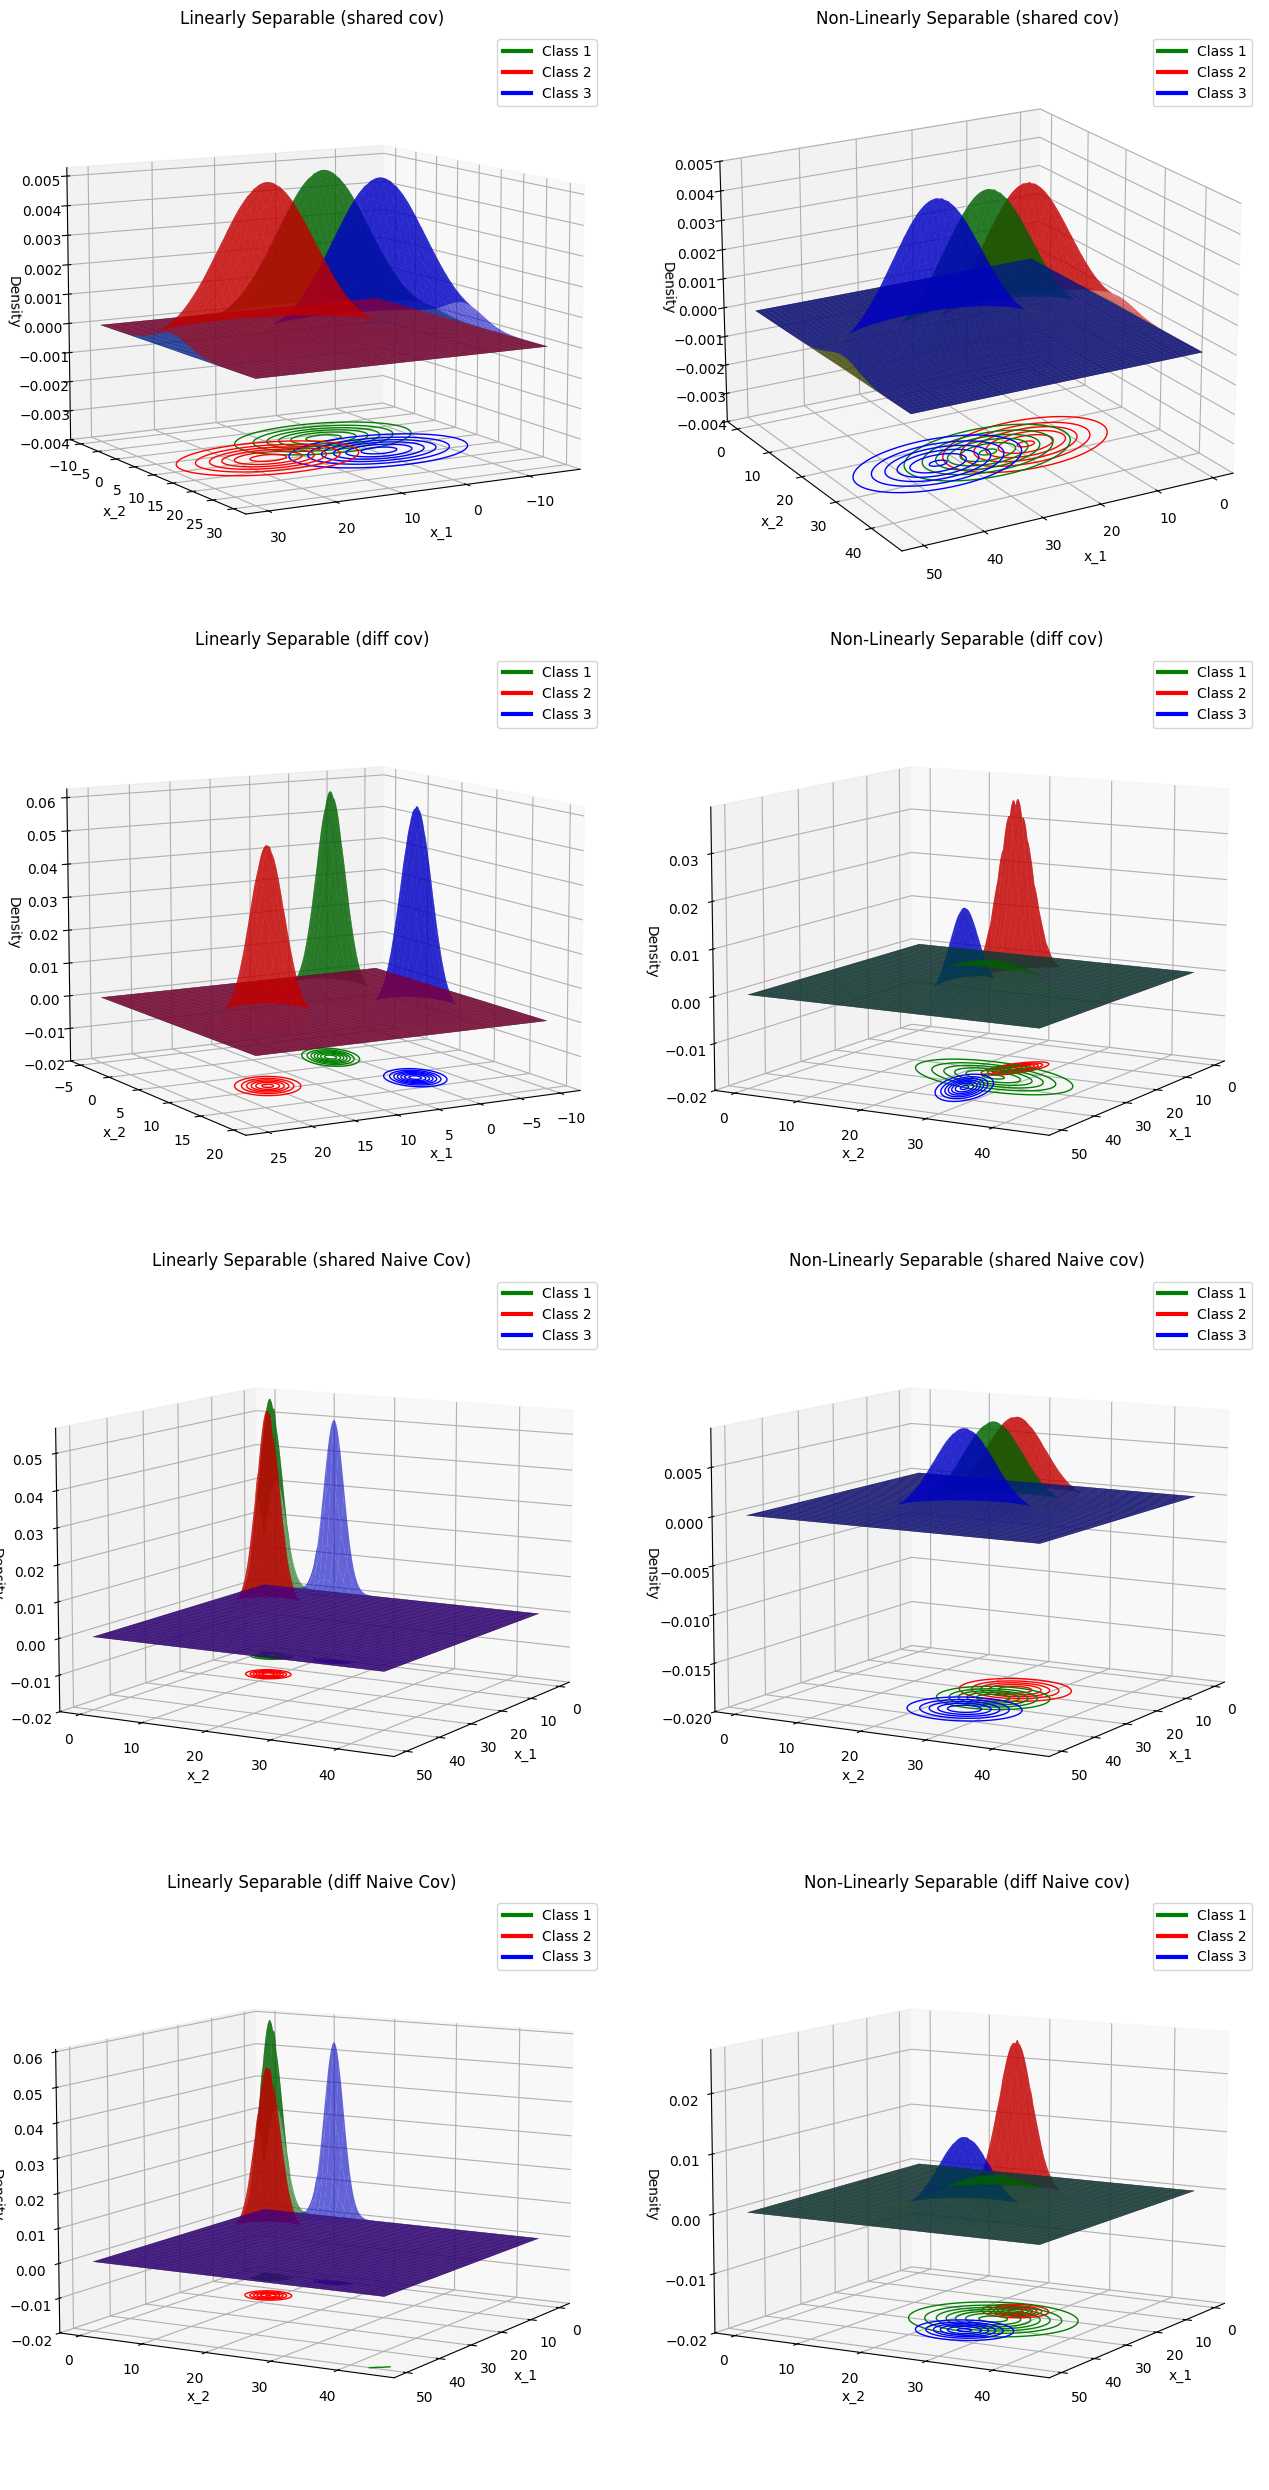

In [ ]:
# Cell type : CodeWrite
# write your code here as instructed.
# (Use the functions written previously)

# The plot of Gaussian pdfs for all classes estimated using the train data (train.txt).
# Refer to sample plots 1 and 3
# (4 Cases x 2 Datasets = 8 plots)

means_LS_case1, covs_LS_case1   = extract_means_and_covs(LS_means, LS_covariances, case=1, shared=True)
means_NLS_case1, covs_NLS_case1 = extract_means_and_covs(NLS_means, NLS_covariances, case=1, shared=True)
means_LS_case2, covs_LS_case2   = extract_means_and_covs(LS_means, LS_covariances, case=2, shared=False)
means_NLS_case2, covs_NLS_case2 = extract_means_and_covs(NLS_means, NLS_covariances, case=2, shared=False)
means_LS_case3, covs_LS_case3   = extract_means_and_covs(LS_means, LS_covariances, case=3, shared=True)
means_NLS_case3, covs_NLS_case3 = extract_means_and_covs(NLS_means, NLS_covariances, case=3, shared=True)
means_LS_case4, covs_LS_case4   = extract_means_and_covs(LS_means, LS_covariances, case=4, shared=False)
means_NLS_case4, covs_NLS_case4 = extract_means_and_covs(NLS_means, NLS_covariances, case=4, shared=False)

fig, axes = plt.subplots(4, 2, figsize=(14, 25), subplot_kw={"projection": "3d"})

plot_pdf(means_LS_case1, covs_LS_case1,
          make_grid(-15, 30, -10, 30),
          "Linearly Separable (shared cov)",ax=axes[0,0], azim=60, elev=10, z_offset=-0.004)

plot_pdf(means_NLS_case1, covs_NLS_case1,
          make_grid(0, 50, 0, 45),
          "Non-Linearly Separable (shared cov)",ax=axes[0,1], azim=60, elev=20, z_offset=-0.004)

plot_pdf(means_LS_case2, covs_LS_case2,
          make_grid(-10, 25, -5, 20),
          "Linearly Separable (diff cov)",ax=axes[1,0], azim=60, elev=10)

plot_pdf(means_NLS_case2, covs_NLS_case2,
          make_grid(0, 50, 0, 45),
          "Non-Linearly Separable (diff cov)",ax=axes[1,1], azim=30, elev=10)

plot_pdf(means_LS_case3, covs_LS_case3,
          make_grid(0, 50, 0, 45),
          "Linearly Separable (shared Naive Cov)",ax=axes[2,0], azim=30, elev=10)

plot_pdf(means_NLS_case3, covs_NLS_case3,
          make_grid(0, 50, 0, 45),
          "Non-Linearly Separable (shared Naive cov)",ax=axes[2,1], azim=30, elev=10)

plot_pdf(means_LS_case4, covs_LS_case4,
          make_grid(0, 50, 0, 45),
          "Linearly Separable (diff Naive Cov)",ax=axes[3,0], azim=30, elev=10)

plot_pdf(means_NLS_case4, covs_NLS_case4,
          make_grid(0, 50, 0, 45),
          "Non-Linearly Separable (diff Naive cov)",ax=axes[3,1], azim=30, elev=10)

plt.tight_layout()
plt.show()



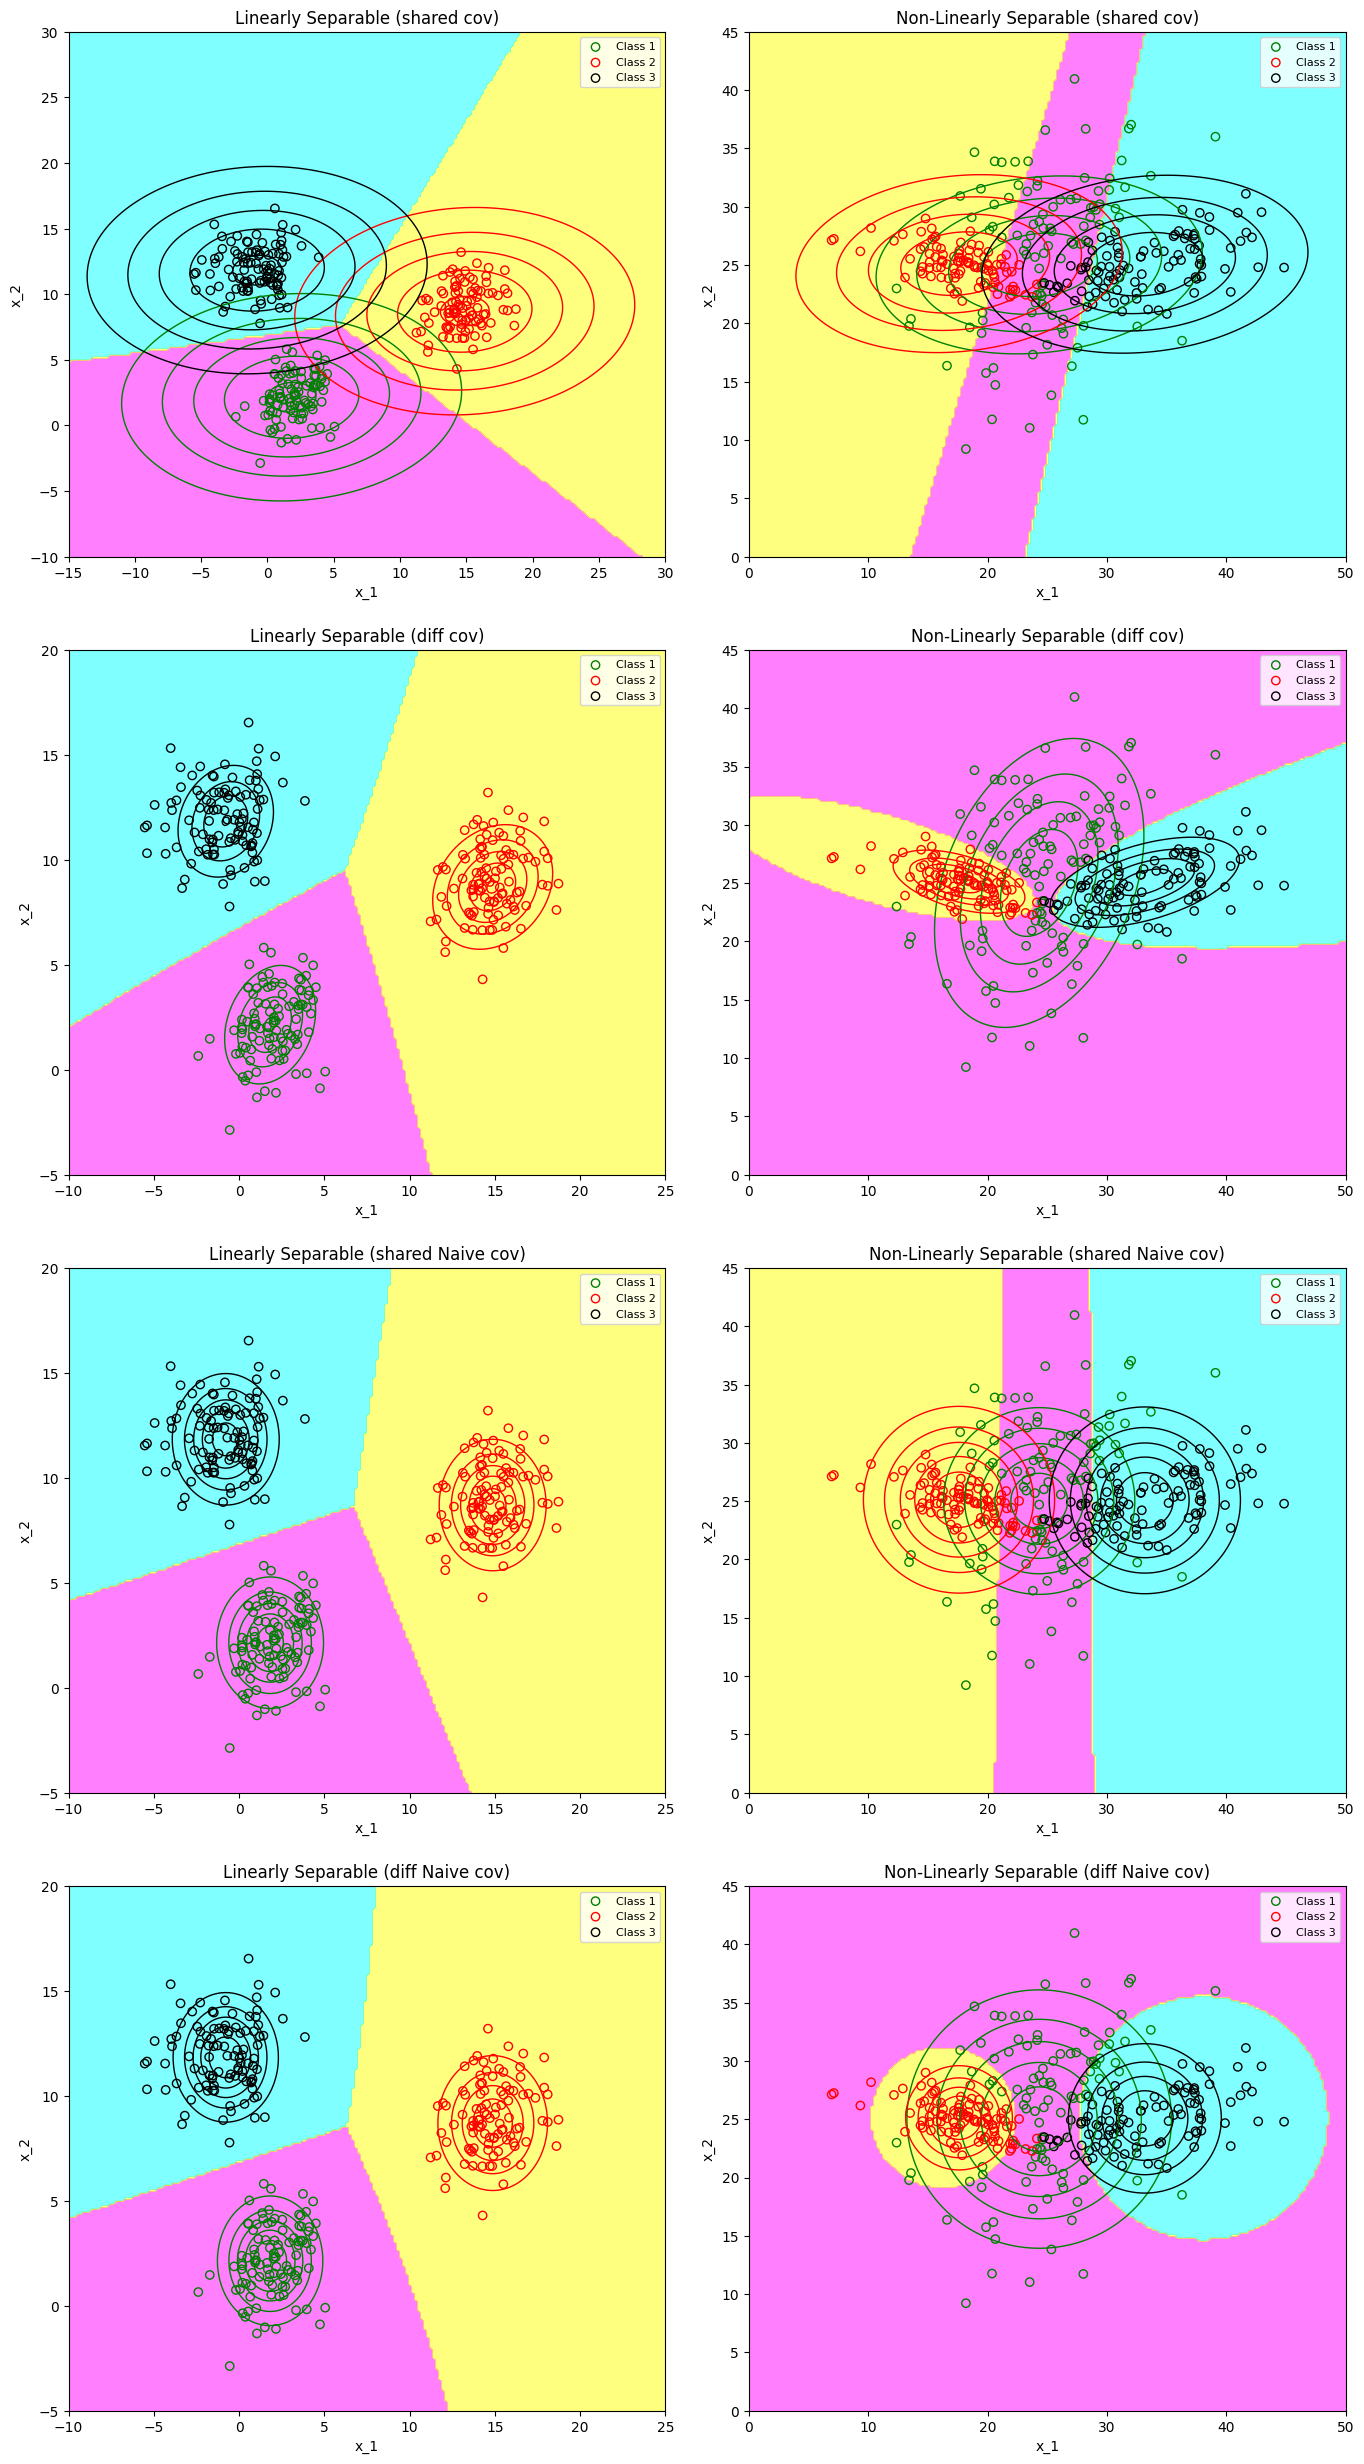

In [ ]:
# Cell type : CodeWrite
# write your code here as instructed.
# (Use the functions written previously)

# The classifiers, specifically their decision boundary/surface as a 2D plot
# along with training points marked in the plot
# Linearly separable data — sample plot 4
# Non-linearly separable data — sample plot 2
#(4 Cases x 2 Datasets = 8 plots)

fig, axes = plt.subplots(4, 2, figsize=(14, 25))

plot_bayes_decision_boundary(means_LS_case1, covs_LS_case1,
    LS_dev, "Linearly Separable (shared cov)", make_grid(-15,30,-10,30), ax=axes[0,0])

plot_bayes_decision_boundary(means_NLS_case1, covs_NLS_case1,
    NLS_dev, "Non-Linearly Separable (shared cov)", make_grid(0,50,0,45), ax=axes[0,1])

plot_bayes_decision_boundary(means_LS_case2, covs_LS_case2,
    LS_dev, "Linearly Separable (diff cov)", make_grid(-10,25,-5,20), ax=axes[1,0])

plot_bayes_decision_boundary(means_NLS_case2, covs_NLS_case2,
    NLS_dev, "Non-Linearly Separable (diff cov)", make_grid(0,50,0,45), ax=axes[1,1])

plot_bayes_decision_boundary(means_LS_case3, covs_LS_case3,
    LS_dev, "Linearly Separable (shared Naive cov)", make_grid(-10,25,-5,20), ax=axes[2,0])

plot_bayes_decision_boundary(means_NLS_case3, covs_NLS_case3,
    NLS_dev, "Non-Linearly Separable (shared Naive cov)", make_grid(0,50,0,45), ax=axes[2,1])

plot_bayes_decision_boundary(means_LS_case4, covs_LS_case4,
    LS_dev, "Linearly Separable (diff Naive cov)", make_grid(-10,25,-5,20), ax=axes[3,0])

plot_bayes_decision_boundary(means_NLS_case4, covs_NLS_case4,
    NLS_dev, "Non-Linearly Separable (diff Naive cov)", make_grid(0,50,0,45), ax=axes[3,1])

plt.tight_layout(pad=2.0)
plt.show()

In [ ]:
# Cell type : CodeWrite
# write your code here as instructed.
# (Use the functions written previously)

# Report the error rates for the above classifiers
# (four classifiers on the two datasets as a 4 × 2 table
# with appropriately named rows and columns).

priors_LS = compute_priors(LS_train)
priors_NLS = compute_priors(NLS_train)

error_LS_shared_bayes = compute_error_rate(LS_dev, means_LS_case1, covs_LS_case1, priors_LS)
error_LS_diff_bayes = compute_error_rate(LS_dev, means_LS_case2, covs_LS_case2, priors_LS)
error_NLS_shared_bayes = compute_error_rate(NLS_dev, means_NLS_case1, covs_NLS_case1, priors_NLS)
error_NLS_diff_bayes = compute_error_rate(NLS_dev, means_NLS_case2, covs_NLS_case2, priors_NLS)
error_LS_shared_naive_bayes = compute_error_rate(LS_dev, means_LS_case3, covs_LS_case3, priors_LS)
error_LS_diff_naive_bayes = compute_error_rate(LS_dev, means_LS_case4, covs_LS_case4, priors_LS)
error_NLS_shared_naive_bayes = compute_error_rate(NLS_dev, means_NLS_case3, covs_NLS_case3, priors_NLS)
error_NLS_diff_naive_bayes = compute_error_rate(NLS_dev, means_NLS_case4, covs_NLS_case4, priors_NLS)

print("Error rates on test data:\n")
print(f"{'Bayes Classifiers':20} | {'Linearly Separable':>20} | {'Non-Linearly Separable':>25}")
print("-"*75)
print(f"{'Shared Covariance':20} | {error_LS_shared_bayes:20.4f} | {error_NLS_shared_bayes:25.4f}")
print(f"{'Different Covariance':20} | {error_LS_diff_bayes:20.4f} | {error_NLS_diff_bayes:25.4f}")
print("-"*75)
print(f"{'Naive-Bayes Classifiers':20} | {'Linearly Separable':>20} | {'Non-Linearly Separable':>25}")
print("-"*75)
print(f"{'Shared Covariance':23} | {error_LS_shared_naive_bayes:20.4f} | {error_NLS_shared_naive_bayes:25.4f}")
print(f"{'Different Covariance':23} | {error_LS_diff_naive_bayes:20.4f} | {error_NLS_diff_naive_bayes:25.4f}")

Error rates on test data:

Bayes Classifiers    |   Linearly Separable |    Non-Linearly Separable
---------------------------------------------------------------------------
Shared Covariance    |               0.0000 |                    0.2333
Different Covariance |               0.0000 |                    0.0267
---------------------------------------------------------------------------
Naive-Bayes Classifiers |   Linearly Separable |    Non-Linearly Separable
---------------------------------------------------------------------------
Shared Covariance       |               0.0000 |                    0.2367
Different Covariance    |               0.0000 |                    0.1533


**Cell type : TextRead**

#### In the next Textwrite cell, answer briefly on whether we can use the most general “Case 2” for all datasets? If not, answer when a simpler model like “Case 1” is preferable over “Case 2”?



**Cell type : TextWrite**
(Write your answer here)

No we can't always use the case-2. It requires estimating more paramertere(i.e. different covariance matrices) and can overfit when the data is limited. Whereas case-1 is simpler mode is preferable when the class covariance are similar, data is roughly linearly separable, or/and the training set is small. -->

**Cell type : TextRead**

#### In the next Textwrite cell, summarise your observations

**Cell type : TextWrite**
(Write your observations here)

From the results, we observe the following:
1. **Linearly Separable Data**
   - All classifiers (Bayes and Naive Bayes, with both shared and different covariance assumptions) achieve an **error rate of 0.0000**.
   - This indicates that the classes are perfectly separable, and even the simplest classifier assumptions are sufficient.

2. **Non-Linearly Separable Data**
   - The **Bayes classifier with different covariances** performs the best, with a very low error rate of **0.0267**, as it models the true class distributions more accurately.
   - The **Bayes classifier with shared covariance** performs worse (**0.2333**), showing that oversimplifying the covariance structure reduces performance.
   - For **Naive Bayes**, the different covariance case performs better (**0.1533**) than the shared covariance case (**0.2367**), but both are less accurate compared to the Bayes classifier.

**Conclusion:**  
The results show that the choice of classifier and covariance assumption significantly impacts performance when data is non-linearly separable, whereas in the linearly separable case, even simple models achieve perfect classification.